In [1]:
# v0 tries DQN
# v1 tries individual actions inatead of doing combinatorials

In [2]:
!pip install --upgrade minerl

Requirement already up-to-date: minerl in /home/user/.local/lib/python3.7/site-packages (0.1.18)


In [123]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output
from IPython import display
import minerl
import pickle
from tqdm import tqdm

import numpy as np
from collections import deque, OrderedDict
import double_dqn_agent
import importlib
importlib.reload(double_dqn_agent)
import math
import types

%matplotlib inline

In [4]:
environment_name = 'MineRLNavigateDense-v0'
%time env = gym.make(environment_name)

CPU times: user 160 ms, sys: 312 ms, total: 472 ms
Wall time: 1min 43s


In [79]:
SEED = 924
NORM_FACTOR = 255

def seed_everything(seed=SEED): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [80]:
ACTIONS_DICT = OrderedDict({#'attack', 
           #'back', 
           'camera_left' : {'camera': [ 0, -20]},
           'camera_right' : {'camera': [ 0, 20]},
           'camera_left_little' : {'camera': [ 0, -5]}, 
           'camera_right_little' : {'camera': [ 0, 5]},
           'forward': {'forward': 1}, 
           #'jump', 
           'jump+forward' : {'forward': 1, 'jump':1},
           'left' : {'left':1},
           #'place',
           'right' : {'right':1}, 
           'sneak+forward' : {'sneak': 1, 'jump':1},
           'wait': {}})
           #'sprint'
    

actions_dim = len(ACTIONS_DICT) # we interpret camera yaw as discrete
print(actions_dim)
print(env.action_space)

10
Dict(attack:Discrete(2), back:Discrete(2), camera:Box(2,), forward:Discrete(2), jump:Discrete(2), left:Discrete(2), place:Enum(none,dirt), right:Discrete(2), sneak:Discrete(2), sprint:Discrete(2))


In [133]:
state_dim = 1+64*64*3 # we ignore inventory
non_visual_state_dim = 1
print(env.observation_space)

Dict(compassAngle:Box(), inventory:Dict(dirt:Box()), pov:Box(64, 64, 3))


In [82]:
actions_items = list(ACTIONS_DICT.items()) # makes code slightly faster
def convert_action_3(action_number):
    return actions_items[action_number][1]

In [130]:
class LayerRotation():
    def __init__(self, init_parameters):
        assert isinstance(init_parameters, types.GeneratorType)
        self.flat_initial_params = self.get_list_flat_params(init_parameters)
        self.torch_pi = torch.tensor(math.pi)
        
    def get_layer_rotation_list(self, parameters):
        flat_params = self.get_list_flat_params(parameters)
        return [self.get_layer_rotation(p,q) for p, q in zip(self.flat_initial_params, flat_params)]     
                
    def get_list_flat_params(self, parameters):
        return [p.view(-1) for p in list(parameters)]
    
    def get_layer_rotation(self, x1, x2):
        return float(torch.acos(torch.cosine_similarity(x1, x2, dim=0))*2/self.torch_pi)
    
layer_rotation = LayerRotation(agent.qnetwork_local.parameters())

In [131]:
# Restart the agent
agent = double_dqn_agent.Agent(non_visual_state_dim, actions_dim, SEED)
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
iterations = 0
epsilons = []
layer_rotations = []

In [132]:
n_episodes=2000 # maximum number of training episodes
max_t=1000 # maximum number of timesteps per episode
eps_start=1.0 #  starting value of epsilon, for epsilon-greedy action selection
eps_end=0.01 # minimum value of epsilon
eps_decay=0.995 # multiplicative factor (per episode) for decreasing epsilon


eps = eps_start                    # initialize epsilon
for i_episode in tqdm(range(1, n_episodes+1)):
    state, _ = env.reset()
    score = 0
    layer_rotations.append(layer_rotation.get_layer_rotation_list(agent.qnetwork_local.parameters()))
    for t in range(max_t):
        action_raw = agent.act([state['pov'].astype(float)], state['compassAngle'], eps)
        action = convert_action(action_raw)   
        next_state, reward, done, info = env.step(action)     
        agent.step(state, action_raw, reward, next_state, done)
        state = next_state
        score += reward 
        iterations += 1
        if done:
            break
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    epsilons.append(eps)
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tMean Score: {:.2f}\tMax score: {:.2f}'.format(i_episode,
                                                                      np.mean(scores_window),
                                                                      np.max(scores_window)))
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f} \tLoss: {:.2f}'.format(i_episode, 
                                                                   np.mean(scores_window),
                                                                   agent.loss))
    if np.mean(scores_window)>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tMean score: {:.2f}\tMax score: {:.2f}'.format(i_episode-100, np.mean(scores_window), np.max(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break

        pickle.dump(scores,open('scores.pickle','wb'))




  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

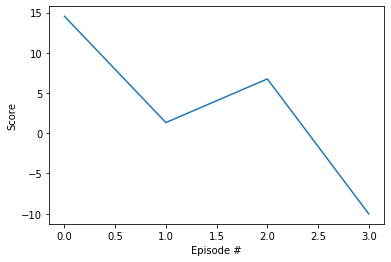

In [108]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [37]:
# torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

In [10]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Total reward:  -7.6007843017578125


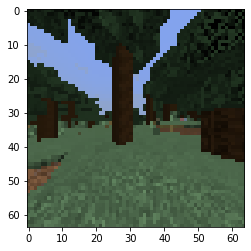

In [42]:
net_reward = 0
state, _ = env.reset()
actions = []
for i in range(200):
    action_raw = agent.act([state['pov'].astype(float)], state['compassAngle'], 0.01)
    action = convert_action(action_raw)  
    actions.append((action, net_reward))
    state, reward, done, info = env.step(
        action)  
    
    if i%10==0:
        plt.imshow(env.render(mode='rgb_array')) 
        display.display(plt.gcf())
        clear_output(wait=True)
    net_reward += reward
print("Total reward: ", net_reward) 

In [43]:
actions

[({'left': 1}, 0),
 ({'left': 1}, -0.0782928466796875),
 ({'left': 1}, -0.199432373046875),
 ({'left': 1}, -0.34410858154296875),
 ({'camera': [0, -20]}, -0.5017547607421875),
 ({'left': 1}, -0.642578125),
 ({'left': 1}, -0.7744598388671875),
 ({'left': 1}, -0.901702880859375),
 ({'left': 1}, -1.026641845703125),
 ({'camera': [0, -20]}, -1.1505508422851562),
 ({'left': 1}, -1.2436676025390625),
 ({'left': 1}, -1.320281982421875),
 ({'left': 1}, -1.388214111328125),
 ({'left': 1}, -1.4516983032226562),
 ({'left': 1}, -1.5130538940429688),
 ({'left': 1}, -1.5735549926757812),
 ({'left': 1}, -1.633880615234375),
 ({'left': 1}, -1.6826019287109375),
 ({'left': 1}, -1.6983566284179688),
 ({'left': 1}, -1.6912612915039062),
 ({'camera': [0, 20]}, -1.5953445434570312),
 ({'left': 1}, -1.5270919799804688),
 ({'left': 1}, -1.5524520874023438),
 ({'left': 1}, -1.6249542236328125),
 ({'camera': [0, 20]}, -1.7234115600585938),
 ({'left': 1}, -1.8590774536132812),
 ({'left': 1}, -2.0151290893554688

Total reward:  -7.900337219238281


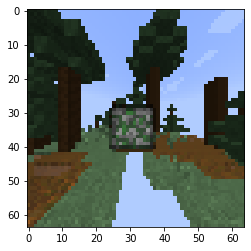

In [99]:
for i in range(200):
    action_raw = agent.act([state['pov'].astype(float)], state['compassAngle'], 0.05)
    action = convert_action(action_raw)  
    actions.append((action, state['compassAngle'], net_reward))
    state, reward, done, info = env.step(
        action)  
    if i%10==0:
        plt.imshow(env.render(mode='rgb_array')) 
        display.display(plt.gcf())
        clear_output(wait=True)
    net_reward += reward
print("Total reward: ", net_reward) 

In [100]:
actions[-50:]

[({'camera': [0, -20]}, -101.80438, -7.888671875),
 ({'camera': [0, 20]}, -100.70087, -7.9160003662109375),
 ({'camera': [0, -20]}, -101.33591, -7.941558837890625),
 ({'camera': [0, 20]}, -101.71118, -7.9590606689453125),
 ({'camera': [0, -20]}, -103.44882, -7.969657897949219),
 ({'left': 1}, -104.53757, -7.971168518066406),
 ({'left': 1}, -105.02042, -7.963584899902344),
 ({'left': 1}, -104.980225, -7.9471588134765625),
 ({'forward': 1}, -104.52521, -7.9223785400390625),
 ({'camera': [0, 20]}, -103.77515, -7.8899383544921875),
 ({'left': 1}, -104.44928, -7.852500915527344),
 ({'left': 1}, -106.20929, -7.8110198974609375),
 ({'camera': [0, 20]}, -108.69745, -7.792778015136719),
 ({'camera': [0, -20]}, -113.16907, -7.830207824707031),
 ({'left': 1}, -117.26959, -7.8605499267578125),
 ({'left': 1}, -120.74536, -7.884132385253906),
 ({'camera': [0, -20]}, -123.44318, -7.900260925292969),
 ({'left': 1}, -123.70288, -7.906791687011719),
 ({'left': 1}, -121.991394, -7.905357360839844),
 ({'l

# DDPG (not implemented yet)

In [0]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", 
                                                                "action", 
                                                                "reward", 
                                                                "next_state", 
                                                                "done",
                                                                "td_error"])
        self.td_errors = []
    
    def add(self, states, actions, rewards, next_states, dones, td_errors):
        """Add a new experience to memory."""
        e = self.experience(states, actions, rewards, next_states, dones, td_errors)
        self.memory.append(e)
        self.td_errors.append(max(td_errors))
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        td_error_probs = self.get_td_errors_probs(self.td_errors)
        elements = np.random.choice(range(len(self.memory)), size=BATCH_SIZE, 
                                    p=td_error_probs, replace=False)
        experiences = [self.memory[element] for element in elements]
        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.stack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.stack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.stack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        td_errors = torch.from_numpy(np.stack([e.td_error for e in experiences if e is not None])).float().to(device)
  
        return (states, actions, rewards, next_states, dones, td_errors)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
        
    def get_td_errors_probs(self, td_errors):
        td_error_probs_scaled = np.abs(td_errors)**PE_ALPHA
        return td_error_probs_scaled / (np.abs(self.td_errors)**PE_ALPHA).sum()

In [12]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.2, sigma=1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.state = copy.copy(self.mu)
        self.size = size
        self.reset()

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.stat
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    
    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

In [13]:
def soft_update(local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [14]:
def layer_init(layer, w_scale=1):
    nn.init.uniform_(layer.weight.data, a=-LAYER_INIT_RANGE, b=LAYER_INIT_RANGE)
    layer.weight.data.mul_(w_scale)
    nn.init.uniform_(layer.bias.data, a=-LAYER_INIT_RANGE, b=LAYER_INIT_RANGE)
    return layer

In [15]:
class QFunction(nn.Module):
    def __init__(self, state_dim, actions_dim, hidden_units=(256, 128), 
                 activation=F.leaky_relu):
        super(QFunction, self).__init__()
        dims = (state_dim + actions_dim, ) + hidden_units + (1, )
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.activation = activation      
        
    def forward(self, state, action, no_grad=False):
        x = torch.cat([state, action], dim=1)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [16]:
class DeterministicPolicy(nn.Module):
    def __init__(self, state_dim, actions_dim, hidden_units=(256, 128) , 
                 activation=F.leaky_relu):
        super(DeterministicPolicy, self).__init__()
        dims = (state_dim,) + hidden_units +(actions_dim,)
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.activation = activation      
        
    def forward(self, state):
        x = state
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return F.tanh( self.layers[-1](x) )

In [23]:
a = env.step(action)

In [26]:
def perform_an_action(state, noise):
    state_tensor = torch.FloatTensor(state).to(device)
    actor.eval() 
    with torch.no_grad():            
        action = actor(state_tensor.unsqueeze(0)).squeeze().detach().cpu().numpy() + noise.sample()
        if ACTION_CLIPPING:
            action = np.clip(action, -1, 1)
    actor.train()
    next_state, reward, done, _ = env.step(action)

    return state, action, reward, next_state, done

In [0]:
# def watch_env(t_max=600, ou_sigma=0):
#     time.sleep(0.1)
#     env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
#     states = env_info.vector_observations / STATES_DIVISOR                # get the current state (for each agent)
#     scores = np.zeros(num_actors)                          # initialize the score (for each agent)
#     noise = OUNoise(size=action_size, theta=ou_sigma, sigma=OU_SIGMA_END)
#     noise_sample = noise.sample()
#     for i in range(t_max):
#         states, actions, rewards, next_states, dones = perform_an_action(states, noise)
#         scores += rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         time.sleep(0.01)
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over actors) this episode: {}'.format(np.mean(scores)))

In [0]:
def train_step():
    states_r, actions_r, rewards_r, next_states_r, dones_r, td_errors_r = replay_buffer.sample()

    weights = 1/ ( replay_buffer.get_td_errors_probs(td_errors_r) * len(replay_buffer))**beta
    for i in range(num_actors):
        #from IPython.core.debugger import Tracer; Tracer()()
        next_actions_all_r = torch.cat([actor_targets[j](next_states_r[:,j,:]) \
                                          for j in range(num_actors)], dim=1)
        critic_target_result = critic_targets[i](adapt_c(next_states_r), 
                                                 next_actions_all_r).squeeze() * (1-dones_r[:,i])

        y = (rewards_r[:,i] + critic_target_result * GAMMA) * weights[:,i].to(device)
        y = y.detach()

        # Train critic
        critic_result = critics[i](adapt_c(states_r), adapt_c(actions_r)).squeeze()
        critic_loss_value = F.mse_loss(critic_result, y)
        critic_optimizers[i].zero_grad()
        critic_loss_value.backward()
        torch.nn.utils.clip_grad_norm_(critics[i].parameters(), GRAD_CLIPPING)
        critic_optimizers[i].step()

        # Train the actor
        actions_all_r = torch.cat([actors[j](states_r[:,j,:]) if (j==i) else\
                                   actors[j](states_r[:,j,:]).detach() for j in range(num_actors)], dim=1)
        change_grad(critics[i], flag_set=False)

        actor_loss_value = -critics[i](adapt_c(states_r), actions_all_r, no_grad=False).mean()
        actor_optimizers[i].zero_grad()
        actor_loss_value.backward()
        torch.nn.utils.clip_grad_norm_(actors[i].parameters(), GRAD_CLIPPING)
        actor_optimizers[i].step()

        change_grad(critics[i], flag_set=True)

        # Update parameters
        soft_update(actors[i], actor_targets[i], TAU)
        soft_update(critics[i], critic_targets[i], TAU)

        # Monitoring
        actions_actor = actors[i](states_r[:,i,:])
        actions_actor_target = actor_targets[i](states_r[:,i,:])
#         store_monitoring(critic_target_result,critic_result, actions_actor, actions_actor_target, y, i)

In [20]:
action = env.action_space.noop()

In [21]:
action

{'attack': 0,
 'back': 0,
 'camera': array([0., 0.], dtype=float32),
 'forward': 0,
 'jump': 0,
 'left': 0,
 'place': 0,
 'right': 0,
 'sneak': 0,
 'sprint': 0}

Total reward:  14.878982543945312


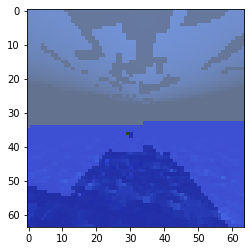

In [0]:
env.

EnvSpec(MineRLNavigateDense-v0)

In [0]:
env.observation_space

Dict(compassAngle:Box(1,), inventory:Dict(dirt:Box(1,)), pov:Box(64, 64, 3))